In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import math
import statistics as sta
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.manifold import Isomap
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB 
from sklearn.ensemble import VotingClassifier
from random import seed
from random import randint
import random

from sklearn.metrics import roc_auc_score
from sklearn import metrics       
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve           

from sklearn import metrics 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve                         # thresholds = all unique prediction probabilities in descending order

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import LocallyLinearEmbedding

import time
import warnings
warnings.filterwarnings('ignore') 

In [2]:
nn = 60
mm = 5

In [42]:
def normalize(dataset):
    dataNorm=(dataset-dataset.mean())/(dataset.std())
    dataNorm["Emotions"]=dataset["Emotions"]
    return dataNorm

def suffle_df(X, i, j, k):
  #a=X.iloc[0:8].copy()
  a=X
  #print(a)
  b,c=a.iloc[0:i+k].copy(),a.iloc[j:j+k].copy()
  b.reset_index(inplace=True, drop=True)
  c.reset_index(inplace=True, drop=True)
  b.index=b.index + j  # modify the values of the index such that 'b' variable can be replaced.

  a.iloc[0:i+k], a.iloc[j:j+k]=c,b
  return(a)
  
def make_dataframes_classes_same_length(x, Eps, prop, rng):
  e0=x[(x['Emotions']==0)]
  e1=x[(x['Emotions']==1)]
  l_e0=len(e0)
  l_e1=len(e1)

  if l_e0>l_e1:
      e1=agument_Data(e1, Eps, prop, rng)
  else:
      e0=agument_Data(e0, Eps, Eps, rng)
  df_to_be_agumented = pd.concat([e0,e1])                   # concat the augmente observation at the end of the array.
  df_to_be_agumented.reset_index(inplace=True, drop=True)   # reset the index
  return df_to_be_agumented 


def agument_Data(x, Eps, proportion, rng, noise_type='gaussian'):
  N=int(proportion*len(x))
  df_to_be_agumented=x

  if noise_type == 'gaussian':
    rn=rng.normal(0, Eps, size=(1, x.shape[1]))
  elif noise_type == 'laplace':
    rn=rng.laplace(0, Eps, size=(1, x.shape[1]))
  elif noise_type == 'uniform':
    rn=rng.uniform(-Eps, Eps, size=(1, x.shape[1]))
  elif noise_type == 'poisson':
    rn=rng.poisson(Eps, size=(1, x.shape[1]))
  else:
    print('Noise type not supported')

  #print('rn=',rn)

  for i in range(N):                            # create new N data. Where N are the required proportion.
    rd_row=random.randint(0,len(x)-1)           # randomly select one row to include noise.
    #print('i',i,'rd_row',rd_row)
    b=x.values[rd_row,0:x.shape[1]]+rn          # add Gaussian Noise to the selected observation.
    b=pd.DataFrame(data=b)                      # return format to Panda Dataframe
    b.columns = x.columns                       # re-name the new dataframe with the original names of the columns
    b.values[0,b.shape[1]-1]=int(x.values[rd_row,b.shape[1]-1]) # convert to integer the last value (this is the value used to classify)
    df_to_be_agumented = pd.concat([df_to_be_agumented,b])      # concat the augmente observation at the end of the array.
    df_to_be_agumented.reset_index(inplace=True, drop=True)     # reset the index
  return(df_to_be_agumented)
  
def train_test_sets(x, i, k, Eps, pr,n,m, nf, col, rng):
  X_test=x.values[i:k,col]
  y_test=x.values[i:k,nf]
  tmp=x.loc[k:len(x)]
  tmp = make_dataframes_classes_same_length(tmp, Eps, pr, rng)
  X_train=tmp.values[k:len(tmp),col]
  y_train=tmp.values[k:len(tmp),nf]

  return X_train, X_test, y_train, y_test


def train_model(nn, mm, file_name, Eps):
  LR_max_iter=500

  prop=0.2

  CV=5
  k=1
  acc_max=0
  for j in range(0,10):
    data = pd.read_csv(file_name, header = None)
    data_name = []
    for i in range(len(data.axes[1])):
      if i== len(data.axes[1])-1:
        data_name = data_name + ['Emotions']
      else:
        data_name = data_name + [str(i)]
    data_n = data_name
    data.columns = data_name
    data=normalize(data)
    nf = data.shape[1]-1 # número de features (componentes)
    nc = nf
    col = list(range(nc))
    random.seed(j)  # 150
    rng=np.random.RandomState(j) # 155, 555
    
    acc_acu=0
    accuracy_acc=0
    N=int(len(data)-k)
    step=1
    i=0
    for n in range(0,N,step):
      i+=1
      wd=data
      ar=suffle_df(wd, 0, n, k)
      X_train, X_test, y_train, y_test = train_test_sets(ar, 0, k, Eps, prop,nn,mm, nf, col, rng)
      model = SVC(kernel='rbf') # random.seed(50), pr=0.2, rand in augmented data=117 : 0.887
      #Fitting de Random Forest
      model.fit(X_train, y_train)
      acc = model.score(X_test, y_test)
      acc_acu += acc
      predictions = model.predict(X_test)
      cm = confusion_matrix(y_test, predictions)
      accuracy= metrics.accuracy_score(y_test, predictions)
      accuracy_acc += accuracy

    acc_ave=acc_acu/i
    if acc_ave > acc_max:
      acc_max=acc_ave
    
    return model, acc_max


In [63]:
stress_historical_accuracy = []
anxiety_historical_accuracy = []
depression_historical_accuracy = []
noise_levels = np.arange(0, 30, 0.1)
for noise_level in noise_levels:
    print("################## Noise Level ", noise_level, '##################')
    stress_model, stress_accuracy = train_model(nn,mm, './stress_data.csv', noise_level)
    anxiety_model, anxiety_accuracy = train_model(nn,mm, './anxiety_data.csv', noise_level)
    depression_model, depression_accuracy = train_model(nn,mm, './depression_data.csv', noise_level)

    print("Stress Accuracy: ", stress_accuracy, " | Anxiety Accuracy: ", anxiety_accuracy, " | Depression Accuracy: ", depression_accuracy)

    stress_historical_accuracy.append(stress_accuracy)
    anxiety_historical_accuracy.append(anxiety_accuracy)
    depression_historical_accuracy.append(depression_accuracy)

################## Noise Level  0.0 ##################
Stress Accuracy:  0.6850393700787402  | Anxiety Accuracy:  0.6456692913385826  | Depression Accuracy:  0.7086614173228346
################## Noise Level  0.1 ##################
Stress Accuracy:  0.6929133858267716  | Anxiety Accuracy:  0.6456692913385826  | Depression Accuracy:  0.7086614173228346
################## Noise Level  0.2 ##################
Stress Accuracy:  0.6929133858267716  | Anxiety Accuracy:  0.6456692913385826  | Depression Accuracy:  0.7086614173228346
################## Noise Level  0.30000000000000004 ##################
Stress Accuracy:  0.6850393700787402  | Anxiety Accuracy:  0.6535433070866141  | Depression Accuracy:  0.7086614173228346
################## Noise Level  0.4 ##################
Stress Accuracy:  0.6771653543307087  | Anxiety Accuracy:  0.6535433070866141  | Depression Accuracy:  0.7165354330708661
################## Noise Level  0.5 ##################
Stress Accuracy:  0.6771653543307087  | Anxi

Text(0, 0.5, 'Accuracy')

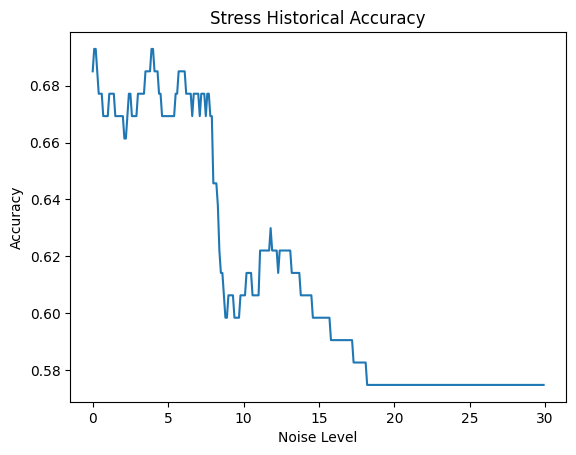

In [64]:
plt.plot(noise_levels, stress_historical_accuracy)
plt.title("Stress Historical Accuracy")
plt.xlabel("Noise Level")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Accuracy')

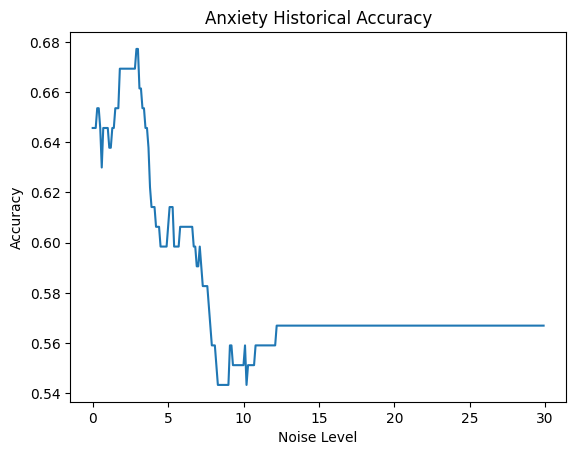

In [65]:
plt.plot(noise_levels, anxiety_historical_accuracy)
plt.title("Anxiety Historical Accuracy")
plt.xlabel("Noise Level")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Accuracy')

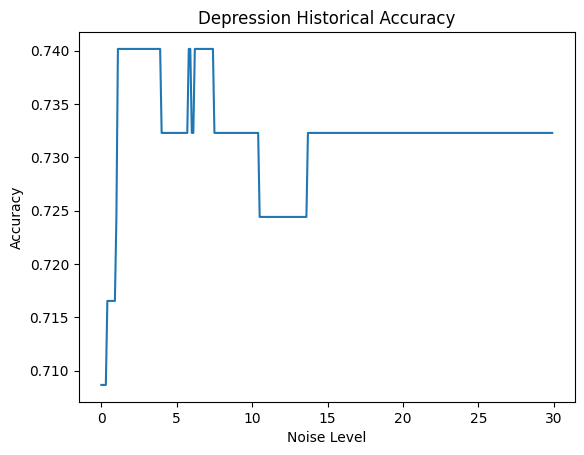

In [66]:
plt.plot(noise_levels, depression_historical_accuracy)
plt.title("Depression Historical Accuracy")
plt.xlabel("Noise Level")
plt.ylabel("Accuracy")